# Object Detection Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถตรวจจับวัตถุได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ นำมาหาค่ากรอบของวัตถุที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตของใบหน้าจำนวน 4 พิกัด พร้อมกับชื่อวัตถุและค่าความเชื่อมั่น (score) <br><br>

![object_landmarks.png](https://raw.github.com/hengkp/mediapipe_examples/main/landmarks/object_landmarks.gif)<br><br>

ในการวัดตำแหน่งของวัตถุจะถูกแบ่งเป็น 9 ทิศทาง ได้แก่ ตรงกลางภาพ, บนขวา, ล่างขวา, บนซ้าย, ล่างซ้าย, กลางขวา, กลางซ้าย, บนกลาง, และล่างกลาง

โดยทำการวัดจากจุดกึ่งกลางของวัตถุ เปรียบเทียบกับจุดกึ่งกลางของภาพ หากระยะห่างของจุดกึ่งกลางวัตถุ *ไม่เกิน 5 เปอร์เซ็น* จากจุดกึ่งกลางภาพ วัตถุนั้นจะถูกนับว่าอยู่ตรงกลางของภาพ

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายทิศทางของวัตถุบนรูป และแสดงผลเป็นรูปภาพที่วาดกรอบสี่เหลี่ยมรอบวัตถุและใส่ชื่อวัตถุพร้อมค่าความเชื่อมั่น โดยประกอบด้วย 8 ขั้นตอนดังต่อไปนี้
<br><br>
![hand_workflow.jpg](https://raw.github.com/hengkp/mediapipe_examples/main/workflows/object_workflow.jpg)

In [9]:
#@title **ขั้นตอนที่ 1** การนำเข้าโมเดลจาก Mediapipe

import requests
import os
import tensorflow as tf

# ที่อยู่ของโมเดลที่ต้องการนำเข้า
model_url = "https://storage.googleapis.com/mediapipe-tasks/object_detector/efficientdet_lite2_uint8.tflite"

# ดาวน์โหลดโมเดลมาเก็บไว้ที่เครื่อง
if not os.path.exists("object_model.tflite"):
    response = requests.get(model_url)
    open("object_model.tflite", "wb").write(response.content)

# นำเข้าโมเดล
model = tf.lite.Interpreter(model_path="object_model.tflite")
model.allocate_tensors()

# เก็บข้อมูลข้อกำหนดของโมเดลสำหรับการเตรียมรูปภาพ
input_details = model.get_input_details()
output_details = model.get_output_details()

In [2]:
#@title **ขั้นตอนที่ 2** นำเข้ารายการชื่อวัตถุของโมเดล

import pandas as pd

class_url = "https://raw.githubusercontent.com/hengkp/mediapipe_examples/main/datasets/labelmap.txt"

# โหลดไฟล์เข้ามาในรูปแบบของ dataframe
df_class = pd.read_csv(class_url, header=None, names=['name'])
df_class.head()

,name
0,person
1,bicycle
2,car
3,motorcycle
4,airplane


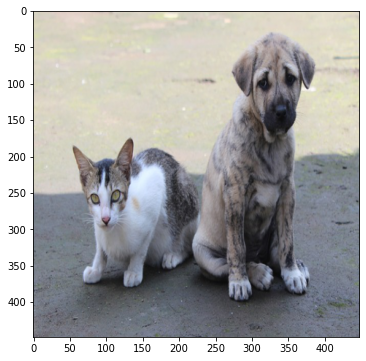

In [4]:
#@title **ขั้นตอนที่ 3-4** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "https://raw.githubusercontent.com/hengkp/mediapipe_examples/main/datasets/cat_and_dog.jpg"

# ขั้นตอนที่ 3 นำเข้าภาพ
img = io.imread(image_path)

# ขั้นตอนที่ 4 ปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(6, 6)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

In [5]:
#@title **ขั้นตอนที่ 5-6** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญ

# ขั้นตอนที่ 5 ประมวลผลภาพ
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# ขั้นตอนที่ 6 ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
boxes = model.get_tensor(output_details[0]['index']) # [ y_start, x_start, y_end, x_end ]
classes = model.get_tensor(output_details[1]['index']).astype(np.uint8) # ID range (0 - 89) = 90 items 
scores = model.get_tensor(output_details[2]['index']) # Accuracy (0 - 1)

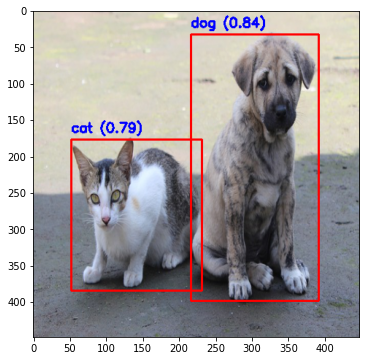

In [7]:
#@title **ขั้นตอนที่ 7** แสดงผลรูปตำแหน่งของวัตถุ

from matplotlib import pyplot as plt
import numpy as np

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# วาดกล่องและใส่ชื่อวัตถุลงในภาพ
for i in range(boxes.shape[1]):
    if scores[0, i] > 0.5:
        box = boxes[0, i, :] * np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]])
        cv2.rectangle(img, (int(box[1]), int(box[0])), (int(box[3]), int(box[2])), (255, 0, 0), 2)
        text = df_class.name[int(classes[0, i])] + " (" + "{:.2f}".format(scores[0, i]) + ")"
        cv2.putText(img, text, (int(box[1]), int(box[0])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# แสดงผลรูปภาพพร้อมพิกัด
plt.imshow(img)
plt.show()

In [8]:
#@title **ขั้นตอนที่ 8** แสดงผลตำแหน่งของวัตถุ

import numpy as np

# ฟังก์ชั่นเพิ่มเติมสำหรับแปลค่าตำแหน่งของวัตถุ
def calculate_position(box, imgsize, alpha=0.05): # alpha: offset-percent
    # คำนวณหาจุดกึ่งกลางของภาพ
    center_image_x = imgsize[2] / 2
    center_image_y = imgsize[1] / 2
    
    # คำนวณหาจุดกึ่งกลางของวัตถุ
    center_object_x = (int(box[1]) + int(box[3])) / 2
    center_object_y = (int(box[0]) + int(box[2])) / 2
    
    # คำนวณค่า cutoff สำหรับแปลค่า
    cutoff_x = np.multiply(center_image_x, np.multiply(alpha,[-1,1])+1)
    cutoff_y = np.multiply(center_image_y, np.multiply(alpha,[-1,1])+1)
    
    # เขียนเงื่อนไขสำหรับตำแหน่งแต่ละพื้นที่ในภาพ
    if center_object_x <= cutoff_x[0] and center_object_y <= cutoff_y[0]:
        location = "upper left"
    elif center_object_x <= cutoff_x[0] and center_object_y >= cutoff_y[1]:
        location = "lower left"
    elif center_object_x >= cutoff_x[1] and center_object_y <= cutoff_y[0]:
        location = "upper right"
    elif center_object_x >= cutoff_x[1] and center_object_y >= cutoff_y[1]:
        location = "lower right"
    elif center_object_x <= cutoff_x[0] and center_object_y >= cutoff_y[0] and center_object_y <= cutoff_y[1]:
        location = "center left"
    elif center_object_x >= cutoff_x[1] and center_object_y >= cutoff_y[0] and center_object_y <= cutoff_y[1]:
        location = "center right"
    elif center_object_x >= cutoff_x[0] and center_object_x <= cutoff_x[1] and center_object_y <= cutoff_y[0]:
        location = "upper center"
    elif center_object_x >= cutoff_x[0] and center_object_x <= cutoff_x[1] and center_object_y >= cutoff_y[1]:
        location = "lower center"
    else:
        location = "center"
    return location

# แสดงชื่อวัตถุพร้อมค่าตำแหน่ง
for i in range(boxes.shape[1]):
    if scores[0, i] > 0.5:
        box = boxes[0, i, :] * np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]])

        # เรียกใช้ฟังก์ชั่นเพื่อคำนวณตำแหน่ง
        location = calculate_position(box, input_details[0]['shape'])
        
        # แสดงผลตำแหน่งของวัตถุนั้น
        print("Position of", df_class.name[int(classes[0, i])], ":", location)

Position of dog : center right
Position of cat : lower left
